<a href="https://colab.research.google.com/github/ToukirSabugar/Object-Detection-and-count-item/blob/main/Using_AI_techniques.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install ultralytics

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.3/41.3 kB 1.8 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.

100%|██████████| 6.74M/6.74M [00:00<00:00, 79.6MB/s]



0: 640x480 2 birds, 468.1ms
Speed: 18.2ms preprocess, 468.1ms inference, 36.4ms postprocess per image at shape (1, 3, 640, 480)


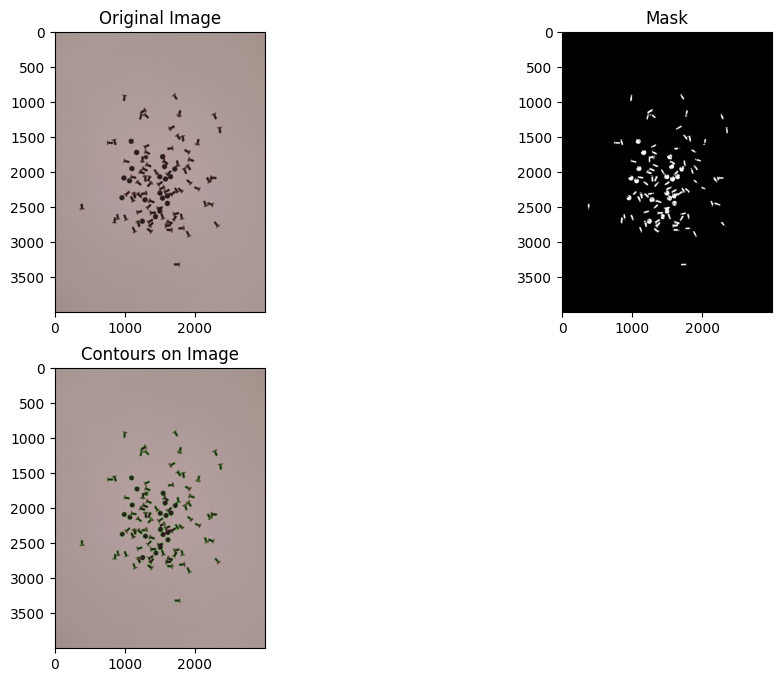

Contours in the image:  100


In [2]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from ultralytics import YOLO

def predict_on_image(model, img, conf):
    result = model(img, conf=conf)[0]

    # Check if masks were detected
    if result.masks is None:
        print("Warning: No masks detected in the image.")
        return None, None, None, None

    # Detection
    cls = result.boxes.cls.cpu().numpy()    # cls, (N, 1)
    probs = result.boxes.conf.cpu().numpy()  # Confidence score, (N, 1)
    boxes = result.boxes.xyxy.cpu().numpy()   # Box with xyxy format, (N, 4)

    # Segmentation
    masks = result.masks.data.cpu().numpy()     # Masks, (N, H, W)

    # Resize each mask individually to match the original image dimensions
    resized_masks = []
    for mask in masks:
        resized_mask = cv2.resize(mask, (img.shape[1], img.shape[0]), interpolation=cv2.INTER_NEAREST)
        resized_masks.append(resized_mask)
    masks = np.array(resized_masks)  # Convert list of masks back to numpy array (N, H, W)

    return boxes, masks, cls, probs

def overlay(image, mask, color, alpha):
    color = color[::-1]
    # Ensure colored_mask has the same number of dimensions as image
    colored_mask = np.expand_dims(mask, -1).repeat(3, axis=-1) * np.array(color)
    # Blend the mask with the image
    image_overlay = cv2.addWeighted(image, 1 - alpha, colored_mask.astype(np.uint8), alpha, 0)
    return image_overlay

def draw_bounding_boxes(image, boxes, color):
    for box in boxes:
        x1, y1, x2, y2 = map(int, box)
        cv2.rectangle(image, (x1, y1), (x2, y2), color, 2)

def filter_and_merge_contours(contours, min_area=100):
    # Filter contours by area
    filtered = [cnt for cnt in contours if cv2.contourArea(cnt) > min_area]

    # List to hold merged contours
    merged_contours = []
    used = [False] * len(filtered)

    for i in range(len(filtered)):
        if not used[i]:
            # Create a new contour that will be merged
            merged = filtered[i]
            used[i] = True

            for j in range(i + 1, len(filtered)):
                if not used[j]:
                    # Check bounding box distance
                    bbox1 = cv2.boundingRect(merged)
                    bbox2 = cv2.boundingRect(filtered[j])
                    dist = np.sqrt((bbox1[0] - bbox2[0])**2 + (bbox1[1] - bbox2[1])**2)

                    if dist < 50:  # Distance threshold for merging
                        merged = np.vstack((merged, filtered[j]))
                        used[j] = True

            merged_contours.append(cv2.convexHull(merged))

    return merged_contours

# Load the model
model = YOLO('yolov8n-seg.pt')

# Load the image using OpenCV
img_path = '/content/20240713_194215.jpg'
img = cv2.imread(img_path)

# Check if the image was loaded successfully
if img is None:
    raise ValueError(f"Image at path '{img_path}' could not be loaded. Please check the path and try again.")

# Predict using YOLOv8
boxes, masks, cls, probs = predict_on_image(model, img, conf=0.4)

if masks is not None:  # Check if masks were returned
    # Overlay masks on the original image
    image_with_masks = np.copy(img)
    for mask in masks:
        image_with_masks = overlay(image_with_masks, mask, color=(0, 255, 0), alpha=0.3)

    # Draw bounding boxes on the image with masks
    draw_bounding_boxes(image_with_masks, boxes if boxes is not None else [], color=(255, 0, 0))

    # Convert image to HSV color space
    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)

    # Define range for black color in HSV
    lower_black = np.array([0, 0, 0])
    upper_black = np.array([180, 255, 50])

    # Threshold the HSV image to get only black colors
    mask = cv2.inRange(hsv, lower_black, upper_black)

    # Apply morphological operations to remove noise
    kernel = np.ones((5, 5), np.uint8)
    mask_cleaned = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel)
    mask_cleaned = cv2.morphologyEx(mask_cleaned, cv2.MORPH_OPEN, kernel)

    # Find contours in the mask
    contours, hierarchy = cv2.findContours(mask_cleaned.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Filter and merge contours
    contours = filter_and_merge_contours(contours, min_area=50)  # Adjust min_area as needed

    # Draw contours on the original image
    rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    cv2.drawContours(rgb, contours, -1, (0, 255, 0), 2)

    # Display the results
    plt.figure(figsize=(12, 8))
    plt.subplot(2, 2, 1)
    plt.title('Original Image')
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

    plt.subplot(2, 2, 2)
    plt.title('Mask')
    plt.imshow(mask_cleaned, cmap='gray')

    plt.subplot(2, 2, 3)
    plt.title('Contours on Image')
    plt.imshow(rgb)

    plt.show()

    print('Contours in the image: ', len(contours))

else:
    print("No masks detected.")
